# Deep Dive into VSS Sales

##### Published: 2020-03-06



## Summary

As of Jan 2015 we have been keeping product level data in SF.  This analysis uses this data, along with seat data from CDB.

For this analysis we should be aware that:

* We only use data from 2015-01-01 onwards for the analysis
* all de-bookings (including Qualcomm). Omitting the de-bookings does over-state bookings to some extent but since many de-bookings are done at the opportunity level rather than at the product level it is a source of error we must accept.  For VSS this does not materially affect the results below.
* Line item discounts and traded in products are treated as opportunity level discounts and applied prorata to all products in the opportunity.
* Product allocation in All-You-Can-Eat deals like Ericsson, SAAB and Nokia can lead to overstating the bookings for a product.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import xlrd
import dtutil.sfdc as sfdc
from dtutil.accounts import Accounts
sys.path.append('/Users/dane/src/datatools/reports')
from pnhelper import get_product_df
import matplotlib.pyplot as plt
from pylab import *
%matplotlib inline
year = '2019'

In [2]:
wod = sfdc.WonOppDict.read_from_file().date_filter('2015-01-01'.format(year), '{}-12-31'.format(year))

# remove opportunities < $0
for k, v in dict(wod).items():
    if v.amt_usd < 0:
        del wod[k]

VSS_products = ['RDR_100', 'RFP_100', 'VSS_150', 'VSS_250', 'VSS_350', 'W5G_100']

sales_dict = wod.sales_by_product()
sales = pd.Series(sales_dict)
wod_l3 = wod.date_filter('{}-01-01'.format(int(year)-2), '{}-12-31'.format(year))
sales_dict_l3 = wod_l3.sales_by_product()
sales_l3 = pd.Series(sales_dict_l3)

# Bookings

Let's start by looking at the cumulative bookings by product.  This gives us a good indication of which part numbers matter most as well as the relative distribution of customer spending.

Because of our 3-year renewal cycle it makes sense to look at things over a 3-year cycle. Looking at yearly bookings  tends to say more about the large deal renewal cycle than it does actual product sales.  Looking at the cumulative bookings for the trailing 3-years gives a better indication or product performance although it is still impacted by currency fluctuations. For product data, we only have 3-years of data so we do not have sufficient data to do historical comparisons yet.

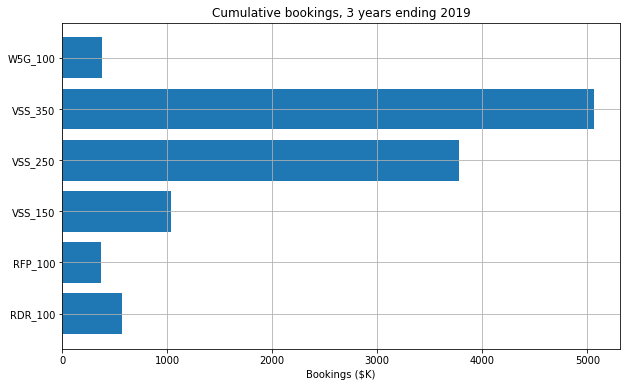

In [3]:
fig = plt.gcf()
fig.set_size_inches(12,1)  
data = sales_l3[VSS_products] / 1000
pos = np.arange(len(data))+.5    # the bar centers on the y axis
fig = plt.gcf()
fig.set_size_inches(10,6)     
barh(pos, data, align='center')
yticks(pos, data.index)
xlabel('Bookings ($K)')
title('Cumulative bookings, 3 years ending {}'.format(year))
grid(True)
show()

While we don't want to read too much into it, it is still worth looking at the yearly bookings

##### Total Bookings by Year ($K)

In [4]:
#print('Total Bookings by Year ($K)')
df = get_product_df(wod, VSS_products)
df.head()
df.groupby('close_year').amt_usd.sum() / 1000

close_year
2015    2144.211169
2016    3101.560321
2017    3259.270790
2018    4151.017905
2019    3784.133334
Name: amt_usd, dtype: float64



## Geographic Breakdown

We can look at the cumulative bookings by territory to get a feel for the geographic distribution.

In [5]:
df = get_product_df(wod_l3, VSS_products)
#df.head(1)
all_products = pd.DataFrame(wod_l3.sales_as_dlist())
#all_products.head(1)

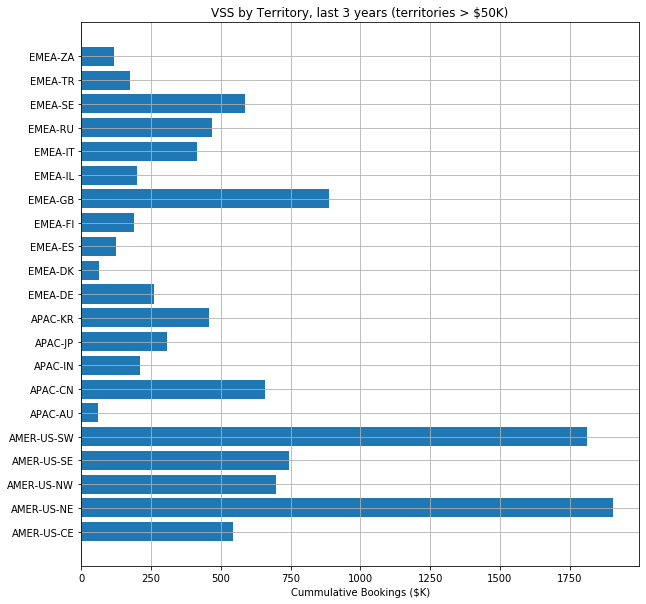

In [6]:
data = df.groupby('territory').amt_usd.sum() / 1000
fig = plt.gcf()
fig.set_size_inches(10,10)
over50 = data[data > 50]
pos = np.arange(len(over50))
barh(pos, over50, align='center')
yticks(pos, over50.index)
xlabel('Cummulative Bookings ($K)')
title('VSS by Territory, last 3 years (territories > $50K)')
grid(True)
show()

This gives a good feel of the size of territories but it can be useful to also have this in tabular form.

##### Bookings by Territory ($K)

In [7]:
#print('Bookings by Territory ($K)')
x = df.groupby(['territory', 'close_year']).amt_usd.sum().unstack().fillna(0) / 1000
x['total'] =  x[2017] + x[2018] + x[2019]
np.round(x[x.index != 'Commission Exempt'], 1)

close_year,2017,2018,2019,total
territory,,,,
AMER-CA-E,6.0,19.9,0.1,26.0
AMER-US-CE,158.1,250.0,136.1,544.2
AMER-US-NE,512.8,622.6,767.7,1903.1
AMER-US-NW,321.8,309.8,67.7,699.3
AMER-US-SE,135.1,275.6,333.0,743.8
AMER-US-SW,400.4,484.3,925.4,1810.1
APAC-AU,38.3,11.6,12.0,61.9
APAC-CN,155.2,359.7,142.3,657.2
APAC-IN,88.1,85.3,37.7,211.1


## Ratio of VSS Sales to Total Sales

Here we look at, for each territory, what percentage VSS is of their total sales.  Basically what part of their customer budgets goes to VSS.

##### Cummulative Bookings and VSS Ratio for Territories with over 50K in Sales

In [8]:
#print('Cummulative Bookings and VSS Ratio for Territories with over 50K in Sales')
vss = df.groupby('territory').amt_usd.sum()
all = all_products.groupby('territory').amt_usd.sum()
r = pd.DataFrame(vss) / 1000
r['pct_of_terr'] = 100 * (vss / all)
np.round(r[r.amt_usd > 50], 1)

,amt_usd,pct_of_terr
territory,,
AMER-US-CE,544.2,6.9
AMER-US-NE,1903.1,14.0
AMER-US-NW,699.3,8.9
AMER-US-SE,743.8,6.2
AMER-US-SW,1810.1,14.7
APAC-AU,61.9,5.7
APAC-CN,657.2,12.5
APAC-IN,211.1,15.7
APAC-JP,308.8,4.9


## Product Type

Our healthiest product lines have a good balance between recurring and non-recurring revenue.  Here we see that VSS has a strong recurring revenue base at 77% of total bookings.

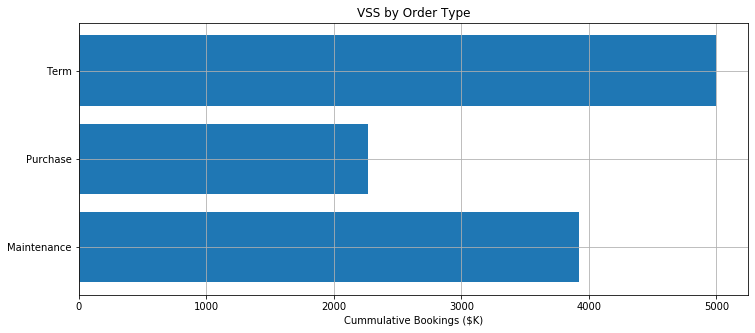

In [9]:
data = df.groupby('order_type').amt_usd.sum() / 1000
fig = plt.gcf()
fig.set_size_inches(12,5)
pos = np.arange(len(data))
barh(pos, data, align='center')
yticks(pos, data.index)
xlabel('Cummulative Bookings ($K)')
title('VSS by Order Type')
grid(True)
show()

#data

We can also compute an estimate of the current yearly recurring revenue by taking 1/3rd of the 2017, 2018 and 2019 3-year deals, 1/2 of the 2018 and 2019 2-year deals and all the of 2019 1-year deals. 

In [10]:
tb = df[(df.order_type != 'Purchase') & df.close_year.isin([2017, 2018, 2019])]
yearly_rr = 0.333 * tb[(tb.years==3)].amt_usd.sum() +\
            0.500 * tb[(tb.years==2) & ((tb.close_year.isin([2018, 2019])))].amt_usd.sum() +\
            1.000 * tb[(tb.years==1) & (tb.close_year == 2019)].amt_usd.sum()
avg_perp = df[df.order_type == 'Purchase'].amt_usd.sum() / 3.0
print('Yearly Time Based Revenue Run Rate = ${:,}'.format(int(yearly_rr)))
print('Average Yearly Perpetual Revenue = ${:,}'.format(int(avg_perp)))
print('Estimated Yearly Run Rate = ${:,}'.format(int(yearly_rr) + int(avg_perp)))

Yearly Time Based Revenue Run Rate = $3,227,557
Average Yearly Perpetual Revenue = $755,808
Estimated Yearly Run Rate = $3,983,365


## Bookings by License Type

Over the last few years we have seen WAN licenses increase in our largest customers. It's interesting to note that 25% of our VSS customers still use locked licenses.

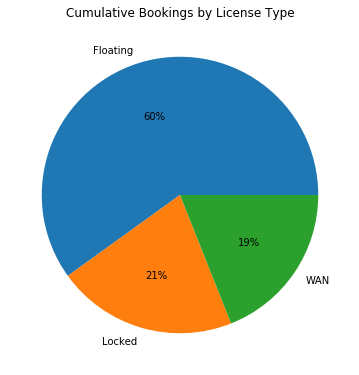

In [11]:
bt = df.groupby('license_type')
x=bt.agg(sum).amt_usd
plt.figure(1, figsize=(6,6))
plt.axes([0.1, 0.1, 0.8, 0.8])
plt.pie(x, labels=x.index, autopct='%1.0f%%')
plt.title('Cumulative Bookings by License Type'.format(year))
plt.show()

Breaking this down by continent we see that this is driven in part by the large locked license use in APAC.

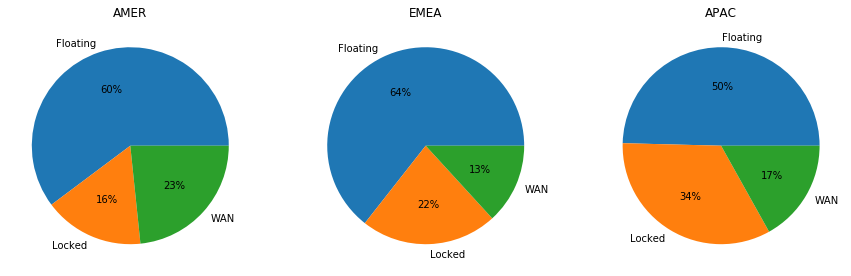

In [12]:
df['continent'] = df.territory.apply(lambda x: x[:4])
# collapse WAN into 1 category
mask = df.license_type.isin(['WAN 1 Timezone', 'WAN 3 Timezones', 'WAN 4 Timezones', 'WAN Worldwide'])
df.loc[mask, 'license_type'] = 'WAN'
btc = df.groupby(['continent','license_type']).agg(sum).amt_usd
plt.figure(1, figsize=(15,5))
sp=1
for continent in ['AMER', 'EMEA','APAC']:
    plt.subplot(1,3,sp) # numrows, numcols, fignum
    sp += 1
    plt.pie(btc[continent], labels=btc[continent].index, autopct='%1.0f%%')
    plt.title('{}'.format(continent))
plt.show()

## Largest Customers

We can rank the customers by their total 3-year spend on VSS products.

**Note:** The two largest customers here are All-You-Can-Eat contracts where we give the customer a large number of seats without them having to pay additionally for them.  This often overstates the bookings allocated to some products such as VSS.  It is quite difficult to know how much these customers would spend on these products if they were on a more standard contract.

##### Largest VSS customers, cumulative bookings in ($K)

*NOTE:* the data for Ericsson below is not correct.  Heikki entered the loaned licenses for VSS as term licenses which causes the VSS allocation to be severely over-stated below.

In [13]:
a = Accounts()
s = df.groupby('custid').amt_usd.sum() / 1000
x = pd.DataFrame(s)
x['name'] = x.index.map(lambda x: a.get_name(int(x)))
np.round(x.sort_values(by='amt_usd', ascending=False)[:20][['name', 'amt_usd']], 1)
#x.head()

,name,amt_usd
custid,,
9305,Ericsson AB - Kista,808.1
9306,Nokia Corporation,375.8
3597,"Mercury Systems, Inc. - Corporate Headquarters",288.6
12117,"Nimbis Services, Inc.",265.5
9636,Space Systems Loral - MDA,252.6
9322,"Smiths Interconnect, Inc. (SII)",252.1
2027,Northrop Grumman - Space Technologies - Redondo,245.4
51,Cobham Defense Electronics - Sensor & Antenna ...,242.1
8813,Honeywell Aerospace - AZ,187.4


# Non-Renewal Business

As we know, bookings includes both renewal business and non-renewal business.  We define New Business as the non-renewal business plus the growth in renewals but often the growth in renewals, while important, is very hard to determine. It is fairly staightforward to look at the non-renewal business.  All non-renewal business should be new business (except in the case of early respins which are often mis-classified).  The benefit of looking at non-renewal business is that it is a component of new business that is not affected by renewal cycles so it can be compared year-to-year to see if it is improving.

##### Non-renewal by year

In [14]:
for k, v in wod.copy().items():
    if v.renewal or (k == '0063900000qJDk3AAG'):  # delete qualcomm as it is a renewal
        del wod[k]
nr_df = get_product_df(wod, VSS_products) 
np.round(nr_df.groupby('close_year').amt_usd.sum() / 1000,0)

close_year
2015     946.0
2016    1135.0
2017    1324.0
2018    1473.0
2019    1773.0
Name: amt_usd, dtype: float64

##### Non-renewal by territory

In [15]:
x = nr_df.groupby(['territory', 'close_year']).amt_usd.sum().unstack().fillna(0) / 1000
x['total'] = x[2015] + x[2016] + x[2017] + x[2018]
np.round(x[x.index != 'Commission Exempt'], 1)

close_year,2015,2016,2017,2018,2019,total
territory,,,,,,
AMER-BR,0.0,38.8,0.0,0.0,0.0,38.8
AMER-CA-E,0.0,0.0,0.0,0.0,0.1,0.0
AMER-US-CE,67.8,8.7,57.2,72.9,42.4,206.5
AMER-US-NE,168.0,90.4,388.7,176.5,306.9,823.5
AMER-US-NW,117.3,52.5,58.4,209.3,26.3,437.6
AMER-US-SE,63.1,42.3,14.7,181.2,262.0,301.4
AMER-US-SW,84.1,89.3,106.7,187.1,461.6,467.2
APAC-AU,0.0,5.4,0.0,0.0,0.0,5.4
APAC-CN,17.1,9.7,69.3,8.2,97.9,104.4


In the western US the booking goal allows us to further break up the sales so it's worth looking at those also.

##### Non-renewal by US booking goal

In [16]:
x = nr_df.groupby(['booking_goal', 'close_year']).amt_usd.sum().unstack().fillna(0) / 1000
x['total'] = x[2015] + x[2016] + x[2017] + x[2018]
np.round(x[x.index.isin(['NA-NE', 'NA-SE', 'NA-TX', 'NA-WJS', 'NA-WVJ'])], 1)

close_year,2015,2016,2017,2018,2019,total
booking_goal,,,,,,
NA-NE,168.0,90.4,388.7,176.5,307.1,823.5
NA-SE,63.1,42.3,14.7,181.2,262.0,301.4
NA-TX,67.8,8.7,57.2,72.9,42.4,206.5
NA-WJS,181.8,76.5,26.7,223.2,347.7,508.2
NA-WVJ,19.6,65.4,138.4,173.2,140.2,396.6


# Seats by Product

So far we have only looked at the bookings per product but it is also useful to look at the seats of products.  Of special interest is looking at how many seats of a product are off maintenance as this often indicates customers that have stopped using the product.

##### Number of licensed seats

In [17]:
from dtutil.sqltools import query_to_dataframe, get_cursor_from_url
cursor = get_cursor_from_url()

In [18]:
query = """
select * from cdb_custdb
    where partno in ({})
        and date = '{}-01-01' and licensed=True 
        and ptype not in ('Loan', 'Home Use')
        and sitetype not in ('NI Academic', 'University')
""".format(','.join(["'{}'".format(x) for x in VSS_products]), int(year)+1)
seats = query_to_dataframe(cursor, query)
# seats.head()

In [19]:
#print('Number of licensed seats')
seats['maintenance'] = 'off'
seats.loc[seats.version=='14.0', 'maintenance'] = 'on'
nls = seats.groupby(['partno', 'maintenance']).qty.sum().unstack().fillna(0)
nls['pct_on_maint'] = np.round(100 * nls['on'] / (nls['off'] + nls['on']), 1)
nls

maintenance,off,on,pct_on_maint
partno,,,
RDR_100,8.0,33.0,80.5
RFP_100,9.0,52.0,85.2
VSS_150,15.0,84.0,84.8
VSS_250,58.0,168.0,74.3
VSS_350,79.0,212.0,72.9
W5G_100,0.0,61.0,100.0


These are very common results where we see mature products with lower percentage on maintenance as there has been a longer time for customers to stop using the product.  The one outlier here is 'RDR_100' which seems to have a very low percentage of seats on maintenace given the newness of the product.

To provide some context, here is the same analysis one our oldest Microwave Office Products.

In [20]:
mquery = """
select * from cdb_custdb
    where partno in ('MWO_226', 'MWO_228')
        and date = '2019-01-01' and licensed=True 
        and ptype not in ('Loan', 'Home Use')
        and sitetype not in ('NI Academic', 'University')
"""
mseats = query_to_dataframe(cursor, mquery)
mseats['maintenance'] = 'off'
mseats.loc[mseats.version=='14.0', 'maintenance'] = 'on'
mnls = mseats.groupby(['partno', 'maintenance']).qty.sum().unstack()
mnls['pct_on_maint'] = np.round(100 * mnls['on'] / (mnls['off'] + mnls['on']), 1)
mnls

maintenance,off,on,pct_on_maint
partno,,,
MWO_226,194,588,75.2
MWO_228,103,330,76.2


## Growth in Licenses

It is also instructive to look at the number of licenses that are active in each country over time.  This allows us to see which countries are increasing their use of VSS and which are going the wrong direction.

##### Total Licensed Seats on Date

In [21]:
query = """
select date, country, sum(qty) as qty from cdb_custdb
    where partno in ('VSS_150', 'VSS_250', 'VSS_350')
        and date like '%-01-01'
        and licensed=True 
        and ptype not in ('Loan', 'Home Use')
        and sitetype not in ('University', 'NI Academic')
group by date, country
order by country, date
"""
lic_by_year = query_to_dataframe(cursor,query)
#lic_by_year.head()

In [22]:
# print('Total Licensed Seats on Date')
pd.pivot_table(lic_by_year, index=['country'], columns=['date'], values=['qty'], aggfunc=[sum], fill_value=0)

sum                                                       
               qty                                                       
date    2015-01-01 2016-01-01 2017-01-01 2018-01-01 2019-01-01 2020-01-01
country                                                                  
AE               1          0          0          0          0          0
AT               1          2          1          1          1          1
AU               6          5          5          5          3          3
BE               0          0          1          1          1          1
BR               0          0          1          1          0          0
CA               8         11          8          6          7          8
CN               3         10         10         21         22         13
CZ               1          1          2          2          2          2
DE              10          7          9         10          9         11
DK               0          0          1          1          2          2
ES               4          4          6          6          6          6
FI              16          5         13         13         12         12
FR               9         10          9          6          7          8
GB              39         38         31         38         37         33
GR               1          1          1          1          1          1
IL              12         16         21         19         17         17
IM               0          0          1          0          0          0
IN              35         36         44         47         49         50
IT               9         11         12         14         16         16
JP              22         25         23         21         20         19
KR              20         20         25         23         25         25
NL               1          1          1          1          1          1
NO               2          2          2          2          2          3
NZ               1          1          2          1          1          1
PL               4          4          3          4          3          3
PT               1          0          0          0          0          0
RU              17         13         18         18         21         22
SE              19         19         11          8         30         30
SG               0          0          1          1          0          1
SI               0          0          0          0          0          1
TR               9          7         11         10         12         16
TW              12          8          8          8          6          6
US             216        211        210        237        260        299
ZA               4          6          5          6          6          5

We can also summarize this to totals by year.

##### Worldwide Licensed Seats on Date

In [23]:
# print('Worldwide Licensed Seats on Date')
lic_by_year.groupby('date').qty.sum()

date
2015-01-01    483
2016-01-01    474
2017-01-01    496
2018-01-01    532
2019-01-01    579
2020-01-01    616
Name: qty, dtype: int64